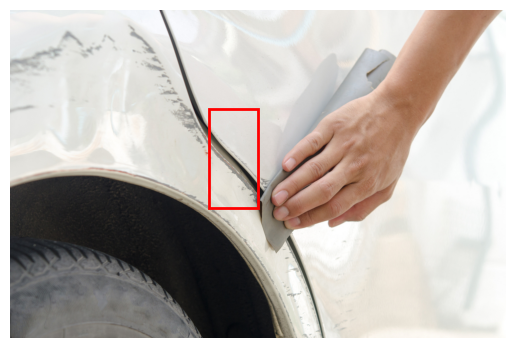

Step 0 loss: 3615.1599
{'loss': tensor(3615.1599, device='cuda:0', grad_fn=<AddBackward0>), 'class_loss': tensor(3614.4165, device='cuda:0', grad_fn=<SumBackward1>), 'box_loss': tensor(0.0149, device='cuda:0', grad_fn=<SumBackward1>)}
Step 10 loss: 3198.0684
{'loss': tensor(3198.0684, device='cuda:0', grad_fn=<AddBackward0>), 'class_loss': tensor(3197.8918, device='cuda:0', grad_fn=<SumBackward1>), 'box_loss': tensor(0.0035, device='cuda:0', grad_fn=<SumBackward1>)}
Step 20 loss: 2739.2256
{'loss': tensor(2739.2256, device='cuda:0', grad_fn=<AddBackward0>), 'class_loss': tensor(2739.1802, device='cuda:0', grad_fn=<SumBackward1>), 'box_loss': tensor(0.0009, device='cuda:0', grad_fn=<SumBackward1>)}
Step 30 loss: 2189.4182
{'loss': tensor(2189.4182, device='cuda:0', grad_fn=<AddBackward0>), 'class_loss': tensor(2189.3911, device='cuda:0', grad_fn=<SumBackward1>), 'box_loss': tensor(0.0005, device='cuda:0', grad_fn=<SumBackward1>)}
Step 40 loss: 1584.4723
{'loss': tensor(1584.4723, device

In [53]:
from functools import partial
from typing import Optional, Tuple
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torchvision.datasets import CocoDetection  # use torchvision, not effdet.data
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain, DetBenchPredict
from effdet.efficientdet import HeadNet

from ml_carbucks import DATA_CAR_DD_DIR
from copy import deepcopy
import torch.nn.functional as F
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# 1. Create config & model
model_name = "tf_efficientdet_d0"  # start with small model
config = get_efficientdet_config(model_name)
config.num_classes = 3  # your classes
config.max_det_per_image = 100
img_path = "/home/bachelor/ml-carbucks/data/car_dd/images/train/002080.jpg"
img_tensor = transforms.ToTensor()(plt.imread(img_path)).cuda()
W = img_tensor.shape[2]
H = img_tensor.shape[1]
config.image_size = (H, W)  # height, width
# Optionally set other config fields:
# config.norm_kwargs = dict(eps=1e-3, momentum=0.01)

# 2. Build model
model = EfficientDet(config, pretrained_backbone=True)
for param in model.backbone.parameters():
    param.requires_grad = True
model.class_net = HeadNet(config, num_outputs=config.num_classes)
model.box_net = HeadNet(config, num_outputs=4)

# At this point, model and config should be consistent

# 3. Wrap for training
bench = DetBenchTrain(model).cuda()
predictor = DetBenchPredict(model).cuda()
optimizer = torch.optim.AdamW(bench.parameters(), lr=1e-3)



C, H, W = img_tensor.shape
imgs = img_tensor[None].cuda()
new_img = deepcopy(img_tensor)
targets = {
    "bbox": [torch.tensor([[ 400.0, 200.0, 500.0, 400.0]]).cuda()],
    "cls": [torch.tensor([0], dtype=torch.long, device='cuda')]
}

plt.imshow(new_img.cpu().permute(1, 2, 0))
plt.axis('off')
bbox = targets["bbox"][0][0].cpu().numpy()
rect = Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                 linewidth=2, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)
plt.show()

bench.train()
for i in range(1000):
    output = bench(imgs, targets)
    loss = output["loss"]
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 10 == 0:
        print(f"Step {i} loss: {loss.item():<.4f}")
        print(output)

    if loss.item() < 0.5:
        print("Loss is low, stopping training.")
        break

Detection 0_0:
  BBox: [ 0.        0.       76.80329  77.007324]
  Score: 0.0540
  Class: 3.0
Detection 0_1:
  BBox: [662.      638.29266 662.      668.7957 ]
  Score: 0.0531
  Class: 2.0
Detection 0_2:
  BBox: [  0.     631.8383   0.     670.8035]
  Score: 0.0524
  Class: 2.0
Detection 0_3:
  BBox: [ 3.0548382  0.        41.29882   21.487309 ]
  Score: 0.0498
  Class: 3.0
Detection 0_4:
  BBox: [ 0.        0.       31.152222 62.593094]
  Score: 0.0496
  Class: 3.0


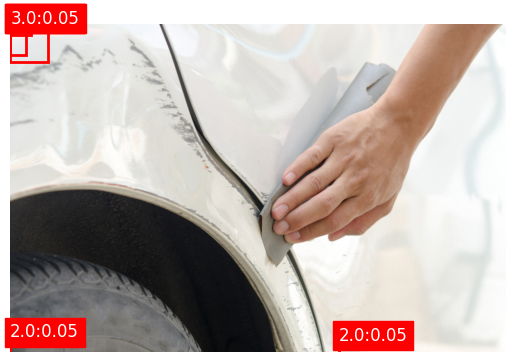

In [55]:
j = 0
predictor.eval()
with torch.no_grad():
    output = predictor(imgs, img_info={"img_size": torch.tensor([[H, W]]).cuda(), "img_scale": torch.tensor([1.0]).cuda()})

sorted_detections = sorted(output[j], key=lambda x: x[4], reverse=True)
ttt = 5
for k, detection in enumerate(sorted_detections[:ttt]): 
    print(f"Detection {j}_{k}:")
    print(f"  BBox: {detection[:4].cpu().numpy()}")
    print(f"  Score: {detection[4].item():.4f}")
    print(f"  Class: {detection[5].item()}")

plt.imshow(imgs[j].cpu().permute(1, 2, 0))
plt.axis('off')
for k, detection in enumerate(sorted_detections[:ttt]):  # show top 5
    bbox = detection[:4].cpu().numpy()
    rect = Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                     linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
    plt.text(bbox[0], bbox[1], f"{detection[5].item()}:{detection[4].item():.2f}", 
             color='white', fontsize=12, backgroundcolor='red')
plt.show()


/tmp/ipykernel_1433880/3165113851.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)        # keep consistent with what you used


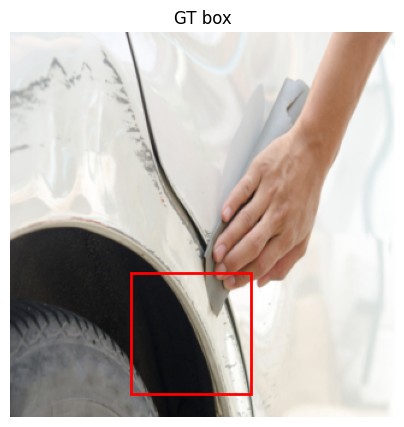

Step 0 loss: 227.605331
Step 50 loss: 61.393955
Step 100 loss: 4.925379
Step 150 loss: 1.516900
Step 200 loss: 0.766272
Step 250 loss: 0.462644
Step 300 loss: 0.314307
Step 350 loss: 0.227951
loss small, stopping at step 375
raw preds sample: tensor([[0.0000e+00, 0.0000e+00, 2.5007e+02, 1.6131e+02, 2.9816e-01, 2.0000e+00],
        [9.0340e+01, 0.0000e+00, 3.2000e+02, 2.8489e+02, 2.9291e-01, 2.0000e+00],
        [0.0000e+00, 0.0000e+00, 3.2000e+02, 1.1353e+02, 2.8370e-01, 1.0000e+00],
        [9.0340e+01, 0.0000e+00, 3.2000e+02, 2.8489e+02, 2.8156e-01, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 3.2000e+02, 3.0377e+02, 2.7590e-01, 3.0000e+00],
        [0.0000e+00, 1.8333e+02, 3.2000e+02, 3.2000e+02, 2.7434e-01, 2.0000e+00],
        [0.0000e+00, 0.0000e+00, 2.5007e+02, 1.6131e+02, 2.7283e-01, 3.0000e+00],
        [0.0000e+00, 0.0000e+00, 5.4073e+01, 3.2000e+02, 2.7268e-01, 2.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.6538e+02, 3.2000e+02, 2.7051e-01, 1.0000e+00],
        [0.0000e+00

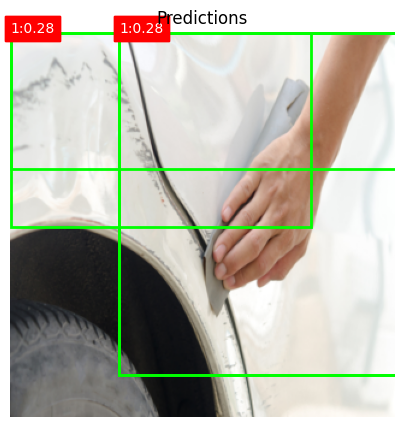

In [5]:
# single_image_overfit_effdet.py
from copy import deepcopy
import torch
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain, DetBenchPredict
from effdet.efficientdet import HeadNet

# ---- CONFIG ----
img_path = "/home/bachelor/ml-carbucks/data/car_dd/images/train/002080.jpg"  # change to your path
DEVICE = "cuda"
SQUARE_SIZE = 320   # IMPORTANT: square size (int). use 320/512/640 depending on model scale
NUM_CLASSES = 3

# ---- Prepare config & model ----
config = get_efficientdet_config("tf_efficientdet_d0")
pil = transforms.ToPILImage()
to_tensor = transforms.ToTensor()
resize = transforms.Resize((SQUARE_SIZE, SQUARE_SIZE))
import imageio
img = imageio.imread(img_path)        # keep consistent with what you used
img_t = to_tensor(resize(pil(img)))   # [C, H, W] with values in [0,1]
imgs = img_t.unsqueeze(0).to(DEVICE)  # [1, C, H, W]
config.num_classes = NUM_CLASSES
H, W = img_t.shape[1], img_t.shape[2]
SQUARE_SIZE = max(H, W)

config.image_size = (SQUARE_SIZE, SQUARE_SIZE) 
config.max_det_per_image = 100

model = EfficientDet(config, pretrained_backbone=True)
# replace classification head only (this is typical)
model.class_net = HeadNet(config, num_outputs=config.num_classes)
# leave box head as default unless you know what you do

model = model.to(DEVICE)

# ---- bench wrappers ----
bench = DetBenchTrain(model).to(DEVICE)

# We'll create predictor AFTER training from bench.model
# predictor = DetBenchPredict(bench.model).to(DEVICE)

# ---- Load & preprocess single image (square resize) ----


# ---- Hardcoded GT box in ORIGINAL image coords -> convert to resized coords ----
# If you already have coordinates in the resized image coordinate system, skip scaling.
# Example: I assume you have coords in original image space and want to map them.
# Here we will assume the box you gave earlier is already in resized coordinates; adapt as needed.

# Example hardcoded bbox (x1, y1, x2, y2) in resized image coordinates:
gt_box = torch.tensor([[100.0, 200.0, 200.0, 300.0]])  # replace if needed
# If these numbers exceed SQUARE_SIZE clamp or rescale them to fit [0, SQUARE_SIZE].
gt_box = gt_box.clamp(min=0, max=SQUARE_SIZE).to(DEVICE)

targets = {
    "bbox": [gt_box],                   # list with one tensor for one image
    "cls": [torch.tensor([0], device=DEVICE, dtype=torch.long)]  # class index list
}

# ---- Visualize image + gt box ----
plt.figure(figsize=(5,5))
plt.imshow(img_t.cpu().permute(1,2,0))
bbox = targets["bbox"][0][0].cpu().numpy()
rect = Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1],
                 linewidth=2, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)
plt.title("GT box")
plt.axis("off")
plt.show()

# ---- Train to overfit this single sample ----
optimizer = torch.optim.AdamW(bench.parameters(), lr=1e-3)

bench.train()
for i in range(1000):
    out = bench(imgs, targets)
    loss = out["loss"]
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 50 == 0:
        print(f"Step {i} loss: {loss.item():.6f}")
    if loss.item() < 0.2:
        print("loss small, stopping at step", i)
        break

# ---- Build predictor from the trained bench.model ----
predictor = DetBenchPredict(bench.model).to(DEVICE)
predictor.eval()

# Prepare img_info: note shapes and dtype must match expectation
img_info = {
    "img_size": torch.tensor([[SQUARE_SIZE, SQUARE_SIZE]], device=DEVICE, dtype=torch.float32),
    "img_scale": torch.tensor([1.0], device=DEVICE, dtype=torch.float32),
}

with torch.no_grad():
    preds = predictor(imgs, img_info=img_info)  # preds is a list-like B x N x 6

print("raw preds sample:", preds[0][:10])  # print top 10 raw preds for inspection

# Filter by confidence and show top-K
conf_thresh = 0.25
filtered = [d for d in preds[0] if d[4].item() >= conf_thresh]
filtered = sorted(filtered, key=lambda x: x[4].item(), reverse=True)
print("kept", len(filtered))

# Visualize top detections
plt.figure(figsize=(5,5))
plt.imshow(img_t.cpu().permute(1,2,0))
ax = plt.gca()
for k, d in enumerate(filtered[:4]):
    x1,y1,x2,y2,score,cls = d.cpu().numpy()
    rect = Rectangle((x1,y1), x2-x1, y2-y1, linewidth=2, edgecolor='lime', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1, f"{int(cls)}:{score:.2f}", color='white', backgroundcolor='red')
plt.axis("off")
plt.title("Predictions")
plt.show()
